# Model Based Machine Learning

## Predictive Maintenance using Probabilistic Graphical Models (PGM)

<div>
    <br/>
    <img src="https://www.analyticsinsight.net/wp-content/uploads/2021/01/Predictive-Maintainance-1024x576.jpg" width="600"/>
</div>

In [2]:
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline
# import sweetviz as sv
import swifter
from IPython.display import display
#matplotlib style options
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)

# Loading data from the different sources

In order to build our predictive maintenance system, we will consider data from 5 sources:

* **Machine conditions and usage**: The operating conditions of a machine e.g. data collected from sensors.
* **Error history**: The history of error codes from the machine.
* **Maintenance history**: The repair history of a machine, e.g. previous maintenance activities or component replacements.
* **Machine features**: The features of a machine, e.g. engine size, make and model, location.
* **Failure history**: The failure history of a machine or component within the machine.

The raw data from these sources was already pre-processed, and relevant features were extracted from it in order to be used in this notebook.

## Machine conditions and usage
It corresponds to sensor data and includes voltage, rotation, pressure and vibration. The raw data was very high-resolution (every 1h) for the problem that we are trying to solve (predict failures 24h in advance). Therefore, for each sensor, features were extracted corresponding to the mean ("mean") and standard deviation ("sd") of the sensor in last 3h, and also in the last 24h window.

In [3]:
# load data from csv
telemetry = pd.read_csv('../data/raw/raw2/PdM_telemetry.csv')

# format datetime field which comes in as string
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

# show first rows
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [4]:
#create a function that takes a column and returns its mean and std of a moving window of 3 hours
def rolling_mean_std(col,window):
    return col.rolling(window).agg(['mean', 'std'])

#apply the function to the telemetry data
def telem_(telemetry,column,window):
    telemetry[[column+'_mean_'+str(window)+'h', column+'_std_'+str(window)+'h']] = telemetry.groupby('machineID')[column].apply(rolling_mean_std,window)
    return telemetry

telemetry = telem_(telemetry,'volt',3)
telemetry = telem_(telemetry,'rotate',3)
telemetry = telem_(telemetry,'pressure',3)
telemetry = telem_(telemetry,'vibration',3)
telemetry = telem_(telemetry,'volt',24)
telemetry = telem_(telemetry,'rotate',24)
telemetry = telem_(telemetry,'pressure',24)
telemetry = telem_(telemetry,'vibration',24)
telemetry=telemetry.drop(['volt','rotate','pressure','vibration'],axis=1)
telemetry=telemetry.dropna()

print(telemetry.shape,telemetry.head())

(873800, 18)               datetime  machineID  volt_mean_3h  volt_std_3h  rotate_mean_3h  \
23 2015-01-02 05:00:00          1    180.133784    21.322735      440.608320   
24 2015-01-02 06:00:00          1    193.164359    10.459846      448.652619   
25 2015-01-02 07:00:00          1    183.273847    13.197149      442.455956   
26 2015-01-02 08:00:00          1    176.364293    18.952210      439.349655   
27 2015-01-02 09:00:00          1    159.676811    11.972868      430.571937   

    rotate_std_3h  pressure_mean_3h  pressure_std_3h  vibration_mean_3h  \
23      48.770512         94.137969         2.135684          41.551544   
24      46.294659        101.438946        11.281152          38.133459   
25      55.701766        103.718215        10.455653          39.226702   
26      51.329636        101.553209        13.789279          36.105580   
27      51.632304        100.242184        12.041639          37.664039   

    vibration_std_3h  volt_mean_24h  volt_std_24h  rota

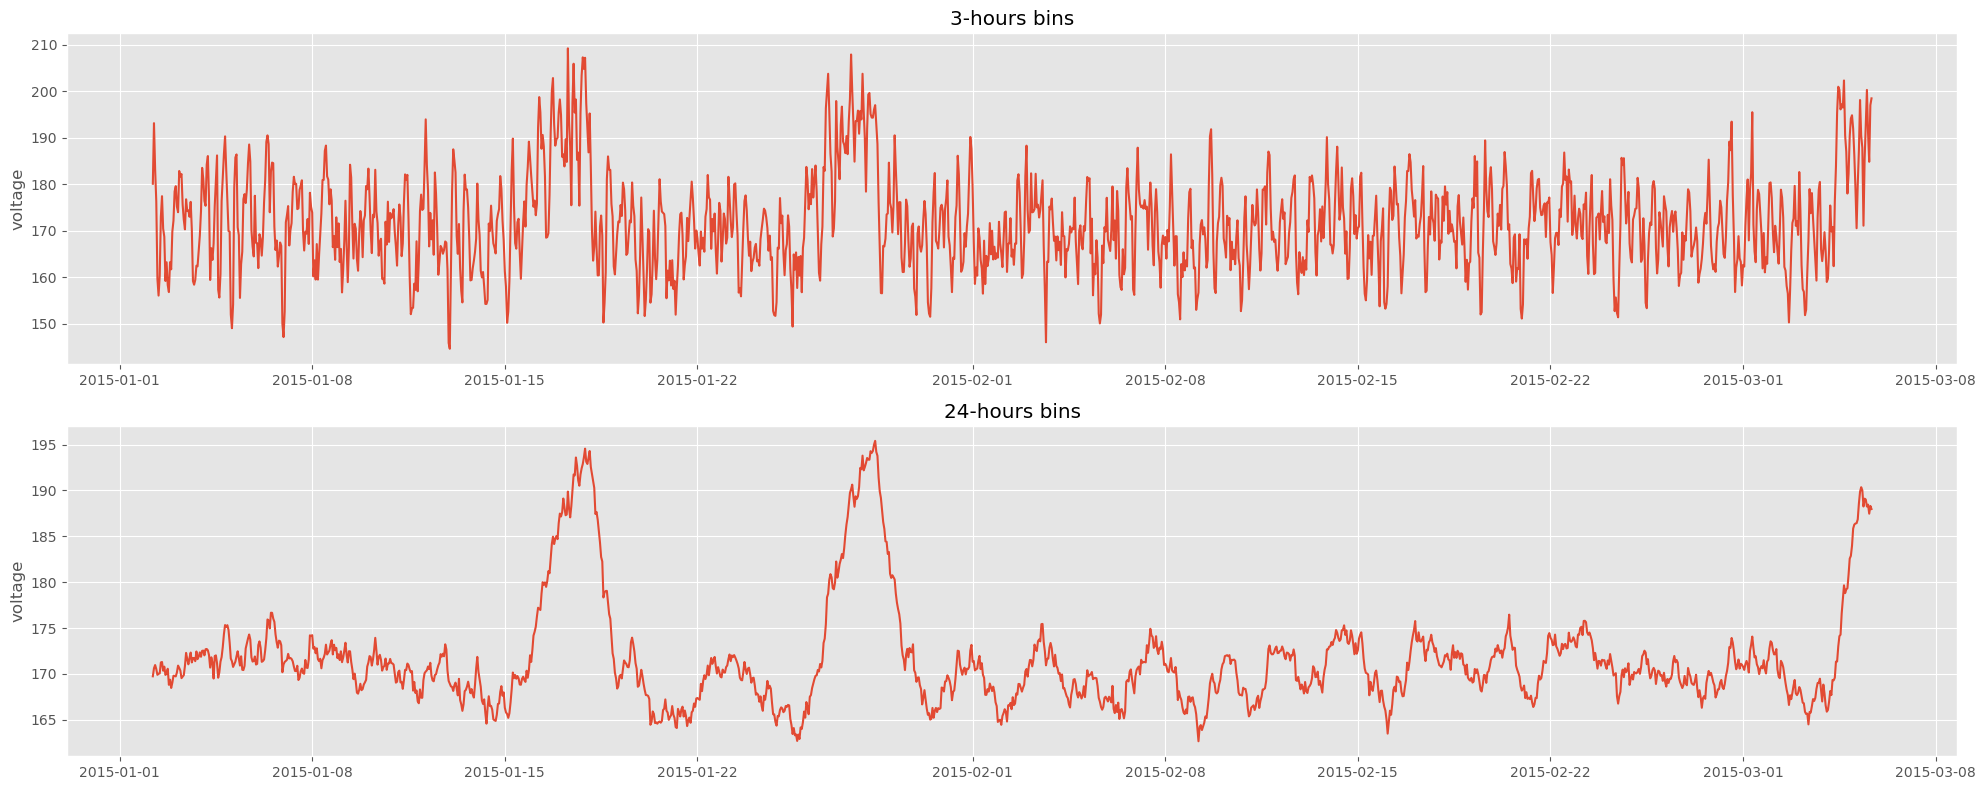

In [5]:
# plot voltage data (3-hour bins) and (24-hour bins)
fig, axs = plt.subplots(2, sharey='row', figsize=(20,8))

axs[0].plot(telemetry[telemetry['machineID'] == 1][:1500]['datetime'], telemetry[telemetry['machineID'] == 1][:1500]['volt_mean_3h'], )
axs[0].set_title("3-hours bins")
axs[0].set_ylabel('voltage')

axs[1].plot(telemetry[telemetry['machineID'] == 1][:1500]['datetime'], telemetry[telemetry['machineID'] == 1][:1500]['volt_mean_24h'], )
axs[1].set_title("24-hours bins")
axs[1].set_ylabel('voltage')

plt.tight_layout()

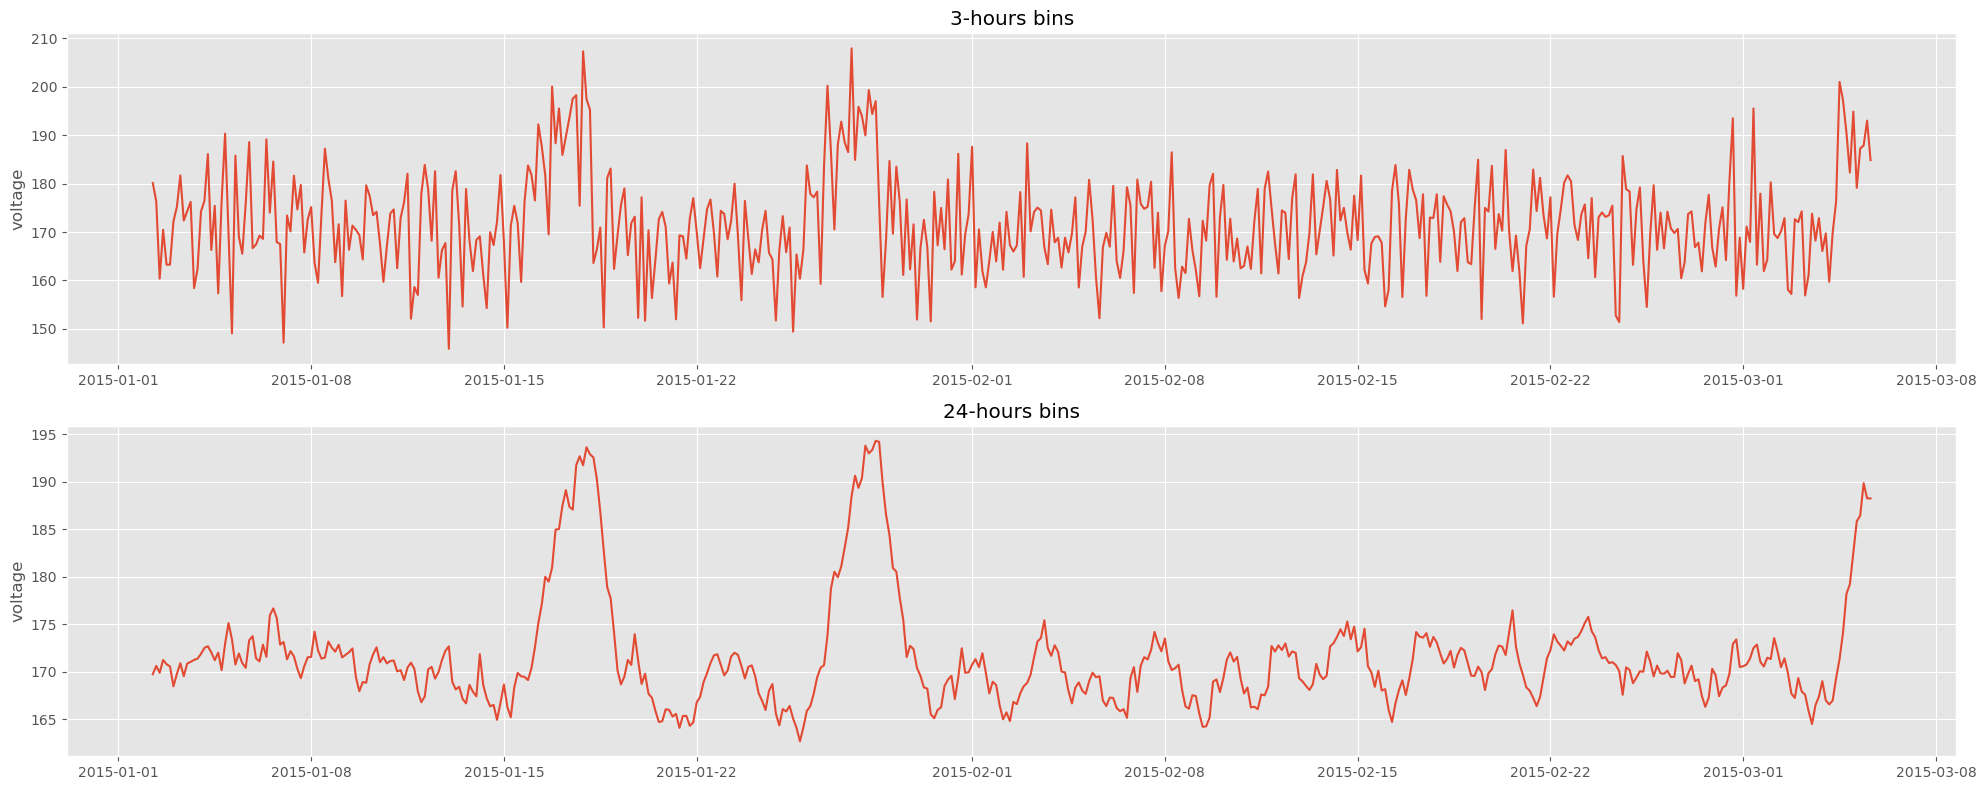

In [14]:
# plot voltage data (3-hour bins) and (24-hour bins)
fig, axs = plt.subplots(2, sharey='row', figsize=(20,8))

axs[0].plot(telemetry[telemetry['machineID'] == 1][:500]['datetime'], telemetry[telemetry['machineID'] == 1][:500]['voltmean_3h'], )
axs[0].set_title("3-hours bins")
axs[0].set_ylabel('voltage')

axs[1].plot(telemetry[telemetry['machineID'] == 1][:500]['datetime'], telemetry[telemetry['machineID'] == 1][:500]['voltmean_24h'], )
axs[1].set_title("24-hours bins")
axs[1].set_ylabel('voltage')

plt.tight_layout()

## Maintenance data

   These are the scheduled and unscheduled maintenance records which correspond to both regular inspection of components as well as failures. A record is generated if a component is replaced during the scheduled inspection or replaced due to a breakdown. 

   Each machine has 4 components, hence the 4 "comp" columns in this dataset. Let's load it with Pandas and make a plot of the days since last component replacement over time for machineID = 1.

In [6]:
# load data from csv
comp_rep = pd.read_csv('../data/raw/comp_rep.csv')

# format datetime field which comes in as string
comp_rep['datetime'] = pd.to_datetime(comp_rep['datetime'], format="%Y-%m-%d %H:%M:%S")

# show first rows
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1.0,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,1.0,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,1.0,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,1.0,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,1.0,19.166667,214.166667,154.166667,169.166667


For the classification part we stick to the initial format of the data where we have the life over the time of a component since the last replacement of it.

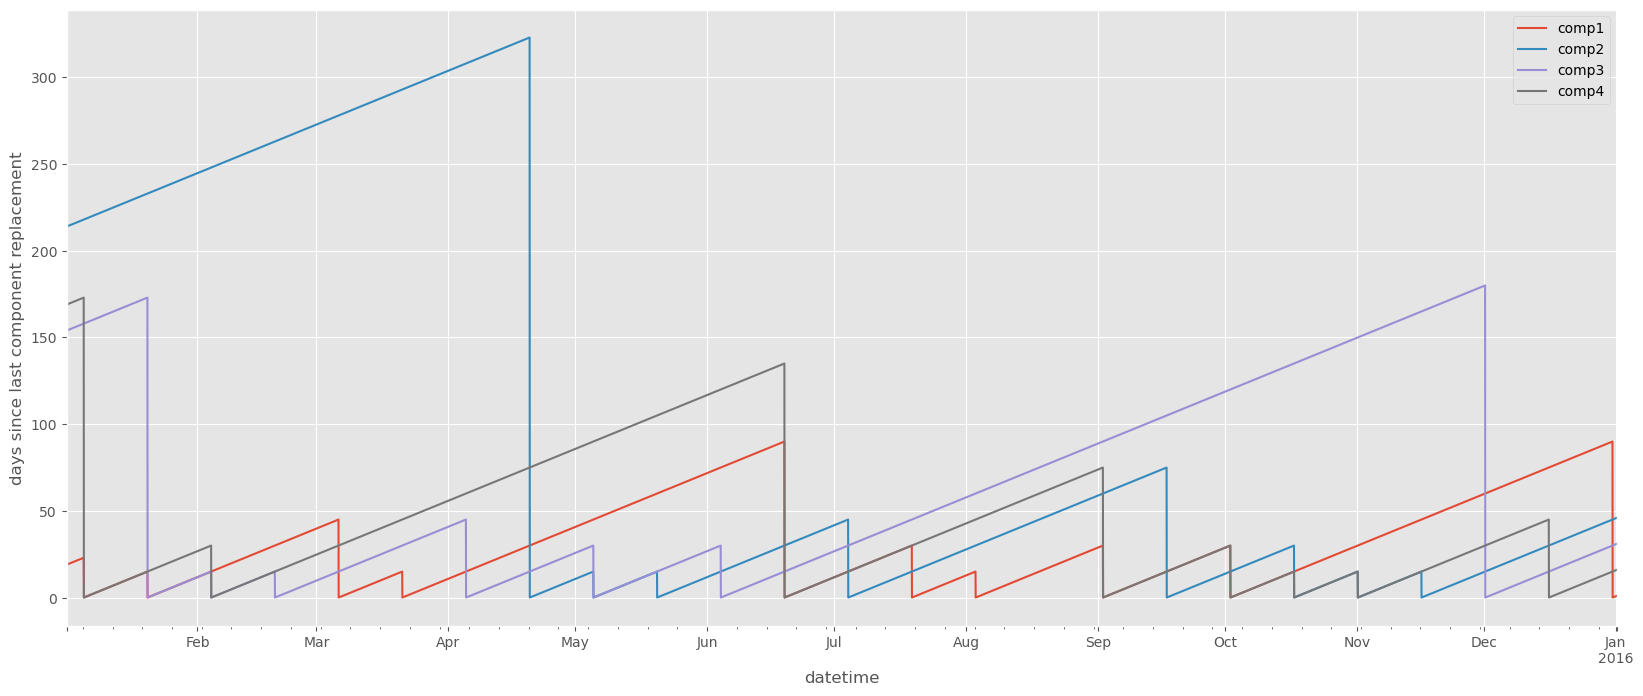

In [26]:
# visualize days since last component replacement for just the first machineID
comp_rep[comp_rep.machineID == 1].plot(x='datetime', 
                                             y=['comp1','comp2','comp3','comp4'],
                                             figsize=(20,8))
plt.ylabel('days since last component replacement')
plt.show()

Regarding the Regression Part we would like to revert the values of components in order to reflect the remaining life of a component until the next replacement of it.

In [9]:
def lifespan(comp_rep0):
    comp_rep=comp_rep0.copy()
    points = comp_rep['machineID'].unique()
    final=pd.DataFrame()

    for i in points:
        df = comp_rep[(comp_rep['machineID']==i)][['datetime','machineID','comp1','comp2','comp3','comp4']]
        for comp in ['comp1','comp2','comp3','comp4']:
            life=comp+'_life'
            df[life] = df.apply(lambda row: row['datetime'] if row[comp]==0 else np.nan, axis=1)
            df[df[life].isna()==False].index
            df[life].fillna(method='backfill', inplace=True)
            df[life] = pd.to_datetime(df[life]) - df['datetime']
            df[life] = df[life].apply(lambda row: row.total_seconds()/86400)
        final=pd.concat([final,df],axis=0)
    return final.copy()

comp_rep_rev=lifespan(comp_rep)
#concat df dataframe to final dataframe


In [15]:
comp_rep_rev.head(100)

,datetime,machineID,comp1,comp2,comp3,comp4,comp1_life,comp2_life,comp3_life,comp4_life
0,2015-01-01 06:00:00,1.0,19.000000,214.000000,154.000000,169.000000,4.000000,109.000000,19.000000,4.000000
1,2015-01-01 07:00:00,1.0,19.041667,214.041667,154.041667,169.041667,3.958333,108.958333,18.958333,3.958333
2,2015-01-01 08:00:00,1.0,19.083333,214.083333,154.083333,169.083333,3.916667,108.916667,18.916667,3.916667
3,2015-01-01 09:00:00,1.0,19.125000,214.125000,154.125000,169.125000,3.875000,108.875000,18.875000,3.875000
4,2015-01-01 10:00:00,1.0,19.166667,214.166667,154.166667,169.166667,3.833333,108.833333,18.833333,3.833333
...,...,...,...,...,...,...,...,...,...,...
95,2015-01-05 05:00:00,1.0,22.958333,217.958333,157.958333,172.958333,0.041667,105.041667,15.041667,0.041667
96,2015-01-05 06:00:00,1.0,0.000000,218.000000,158.000000,0.000000,0.000000,105.000000,15.000000,0.000000
97,2015-01-05 07:00:00,1.0,0.041667,218.041667,158.041667,0.041667,14.958333,104.958333,14.958333,29.958333
98,2015-01-05 08:00:00,1.0,0.083333,218.083333,158.083333,0.083333,14.916667,104.916667,14.916667,29.916667


In [11]:
comp_rep_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876100 entries, 0 to 876099
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   datetime    876100 non-null  datetime64[ns]
 1   machineID   876100 non-null  float64       
 2   comp1       876100 non-null  float64       
 3   comp2       876100 non-null  float64       
 4   comp3       876100 non-null  float64       
 5   comp4       876100 non-null  float64       
 6   comp1_life  779500 non-null  float64       
 7   comp2_life  764020 non-null  float64       
 8   comp3_life  779500 non-null  float64       
 9   comp4_life  770860 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 73.5 MB


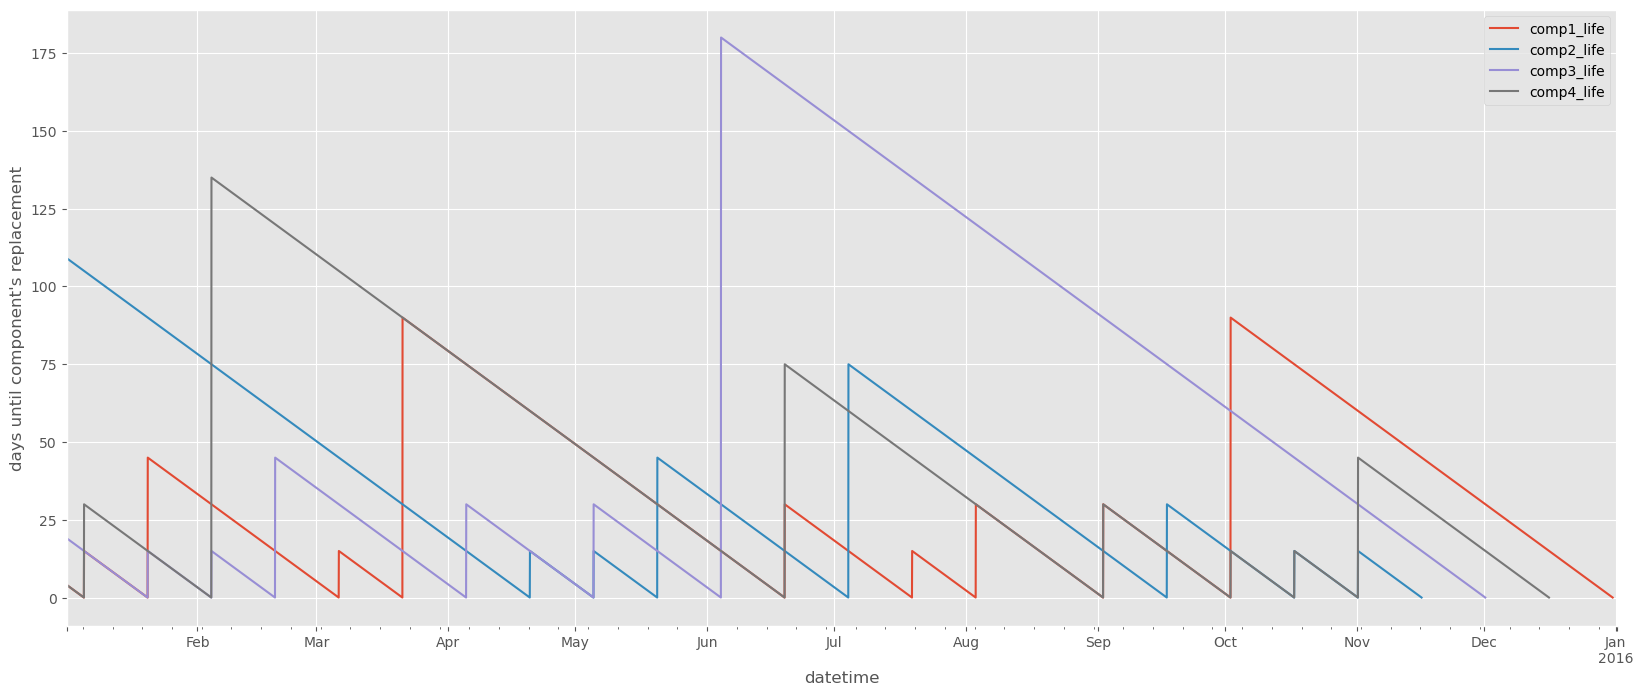

In [22]:
# visualize days since last component replacement
comp_rep_rev[comp_rep['machineID']==1].plot(x='datetime', y=['comp1_life','comp2_life','comp3_life','comp4_life'], figsize=(20,8))
plt.ylabel("days until component's replacement")
plt.show()

# Error Data

These are non-breaking errors thrown while the machine is still operational and do not constitute as failures. Each machine has different components, each of which can fail at any moment. However, before they fail, it is common for a machine to start registering error codes indicating that something may not be well.

In [23]:
# load data from csv
error_count = pd.read_csv('../data/raw/error_count.csv')

# format datetime field which comes in as string
error_count['datetime'] = pd.to_datetime(error_count['datetime'], format="%Y-%m-%d %H:%M:%S")

# show first rows
error_count.head()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
0,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
1,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
2,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
3,1,2015-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
4,1,2015-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0


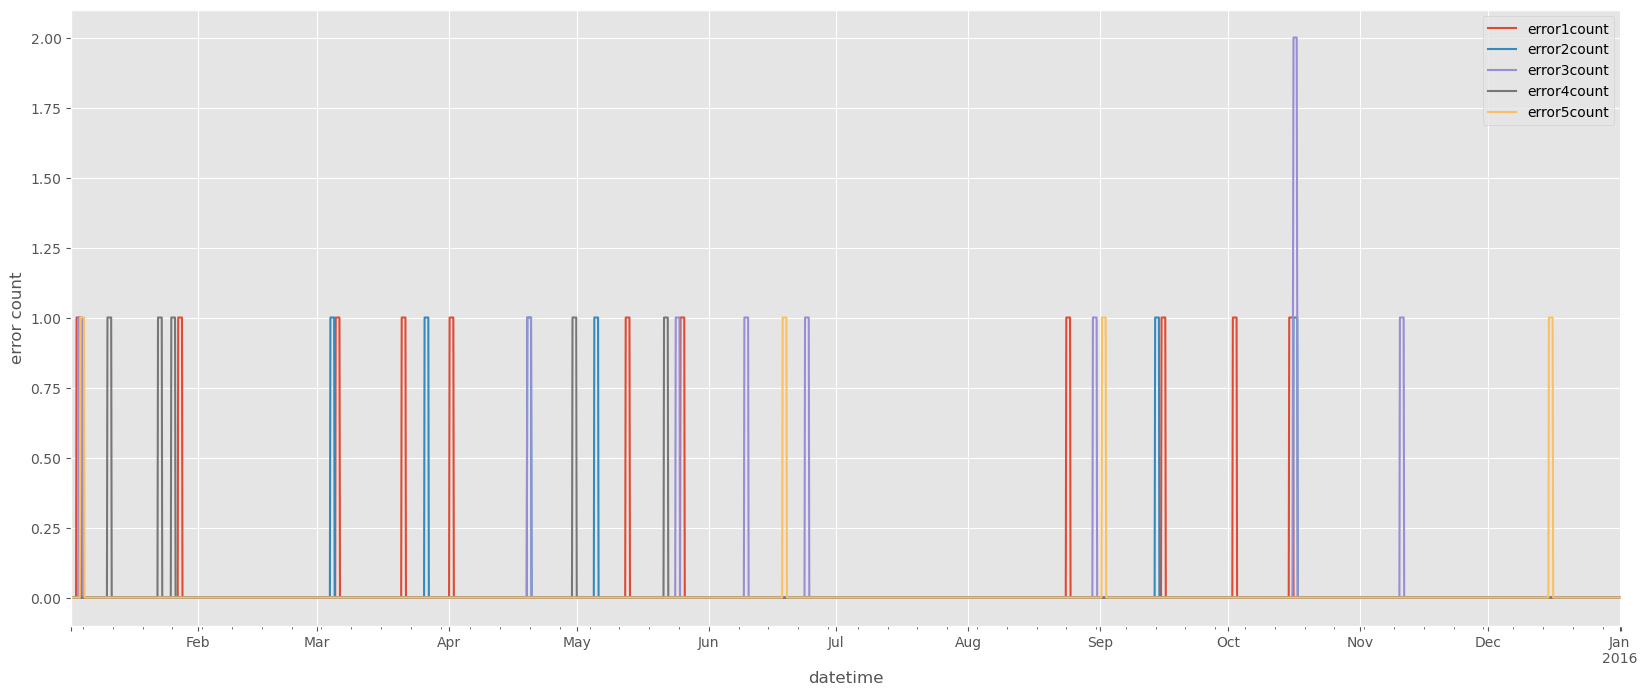

In [24]:
# visualize error count data for one machine

error_count[error_count.machineID == 1].plot(x='datetime', 
                                             y=['error1count','error2count','error3count','error4count','error5count'],
                                             figsize=(20,8))
plt.ylabel('error count')
plt.show()



## Machine characteristics

Information about each machine's model and how old it is.

In [25]:
# load data from csv
machines = pd.read_csv('../data/raw/machines.csv')

# show first rows
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [26]:
# turn "model" variable into dummy variables
machines['model'] = machines['model'].astype('category')
machines = pd.get_dummies(machines)
machines.head()

,machineID,age,model_model1,model_model2,model_model3,model_model4
0,1,18,0,0,1,0
1,2,7,0,0,0,1
2,3,8,0,0,1,0
3,4,7,0,0,1,0
4,5,2,0,0,1,0


## Failure Data

Lastly, the most important data source: the failure logs. This is registry of dates and times when each of the components (1-4) failed.

In [27]:
# load data from csv
failures = pd.read_csv('../data/raw/failures.csv')

# format datetime field which comes in as string
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
#failures['failure'] = failures['failure'].astype('category')

print("Total number of failures: %d" % len(failures.index))
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


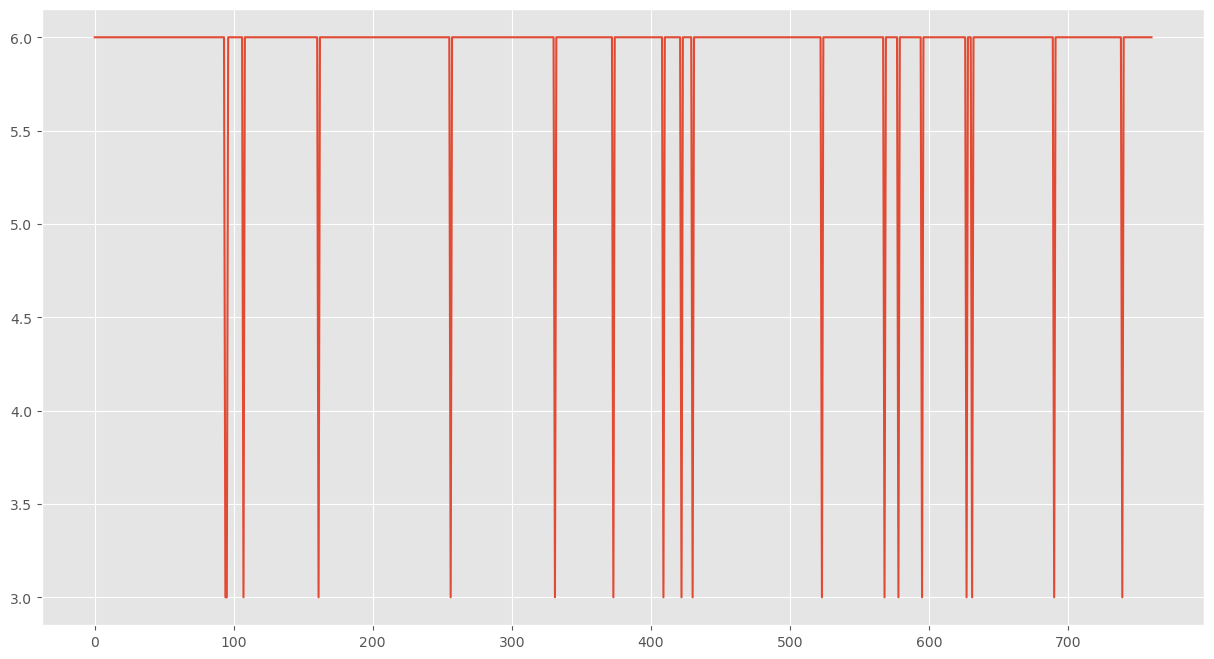

In [28]:
plt.plot(failures['datetime'].apply(lambda x: x.hour))

comp2    259
comp1    192
comp4    179
comp3    131
Name: failure, dtype: int64

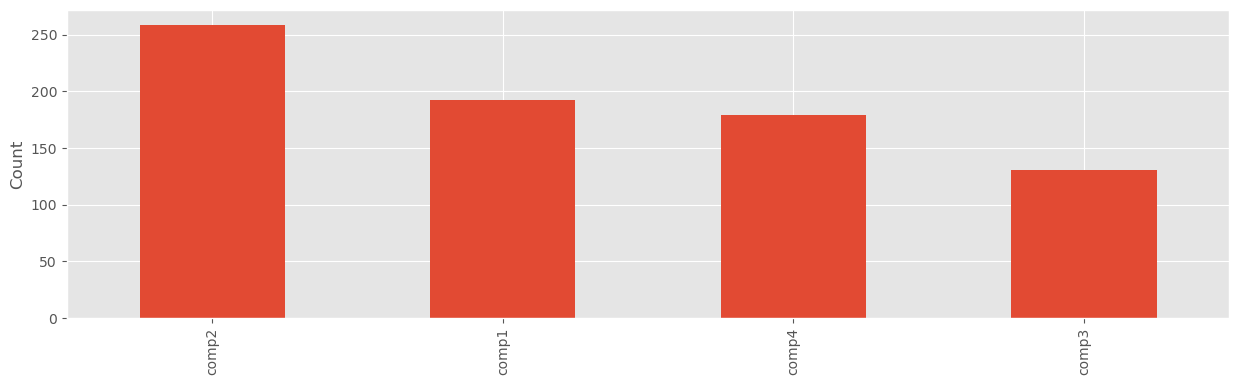

In [29]:
# plot distribution of failures by component
plt.figure(figsize=(15, 4))
failures['failure'].value_counts().plot(kind='bar')
plt.ylabel('Count')
failures['failure'].value_counts()

## Data Merging and Alignment

In [30]:
telemetry.head()

,datetime,machineID,volt_mean_3h,volt_std_3h,rotate_mean_3h,rotate_std_3h,pressure_mean_3h,pressure_std_3h,vibration_mean_3h,vibration_std_3h,volt_mean_24h,volt_std_24h,rotate_mean_24h,rotate_std_24h,pressure_mean_24h,pressure_std_24h,vibration_mean_24h,vibration_std_24h
23,2015-01-02 05:00:00,1,180.133784,21.322735,440.608320,48.770512,94.137969,2.135684,41.551544,10.037208,169.733809,11.233120,445.179865,48.717395,96.797113,10.079880,40.385160,5.853209
24,2015-01-02 06:00:00,1,193.164359,10.459846,448.652619,46.294659,101.438946,11.281152,38.133459,12.407322,170.614862,12.519402,446.364859,48.385076,96.849785,10.171540,39.736826,6.163231
25,2015-01-02 07:00:00,1,183.273847,13.197149,442.455956,55.701766,103.718215,10.455653,39.226702,11.794329,170.961598,12.410607,445.610629,49.228285,97.179484,10.252470,39.419434,6.161772
26,2015-01-02 08:00:00,1,176.364293,18.952210,439.349655,51.329636,101.553209,13.789279,36.105580,6.737739,170.525721,12.591948,443.906847,46.930282,97.667249,9.406795,39.786670,6.098173
27,2015-01-02 09:00:00,1,159.676811,11.972868,430.571937,51.632304,100.242184,12.041639,37.664039,4.682870,169.893965,13.370357,447.009407,42.432317,97.715600,9.471669,39.498374,6.195076


In [31]:
error_count.head()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
0,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
1,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
2,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
3,1,2015-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
4,1,2015-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0


In [46]:
telemetry.shape, error_count.shape, comp_rep.shape, machines.shape

((873800, 18), (291400, 7), (876100, 10), (100, 6))

In [47]:
features = telemetry.merge(error_count, on=['datetime', 'machineID'], how='left')
#features = features.merge(comp_rep, on=['datetime', 'machineID'], how='left')
features = features.merge(machines, on=['machineID'], how='left')
features = features.merge(comp_rep_rev, on=['datetime', 'machineID'], how='left')
features[['error1count','error2count','error3count','error4count','error5count']] = features[['error1count','error2count','error3count','error4count','error5count']].fillna(method='bfill')

features.isna().sum()

datetime                   0
machineID                  0
volt_mean_3h               0
volt_std_3h                0
rotate_mean_3h             0
rotate_std_3h              0
pressure_mean_3h           0
pressure_std_3h            0
vibration_mean_3h          0
vibration_std_3h           0
volt_mean_24h              0
volt_std_24h               0
rotate_mean_24h            0
rotate_std_24h             0
pressure_mean_24h          0
pressure_std_24h           0
vibration_mean_24h         0
vibration_std_24h          0
error1count                0
error2count                0
error3count                0
error4count                0
error5count                0
age                        0
model_model1               0
model_model2               0
model_model3               0
model_model4               0
comp1                      0
comp2                      0
comp3                      0
comp4                      0
comp1_life             96600
comp2_life            112080
comp3_life    

In [48]:
features.head()

,datetime,machineID,volt_mean_3h,volt_std_3h,rotate_mean_3h,rotate_std_3h,pressure_mean_3h,pressure_std_3h,vibration_mean_3h,vibration_std_3h,...,model_model3,model_model4,comp1,comp2,comp3,comp4,comp1_life,comp2_life,comp3_life,comp4_life
0,2015-01-02 05:00:00,1,180.133784,21.322735,440.608320,48.770512,94.137969,2.135684,41.551544,10.037208,...,1,0,19.958333,214.958333,154.958333,169.958333,3.041667,108.041667,18.041667,3.041667
1,2015-01-02 06:00:00,1,193.164359,10.459846,448.652619,46.294659,101.438946,11.281152,38.133459,12.407322,...,1,0,20.000000,215.000000,155.000000,170.000000,3.000000,108.000000,18.000000,3.000000
2,2015-01-02 07:00:00,1,183.273847,13.197149,442.455956,55.701766,103.718215,10.455653,39.226702,11.794329,...,1,0,20.041667,215.041667,155.041667,170.041667,2.958333,107.958333,17.958333,2.958333
3,2015-01-02 08:00:00,1,176.364293,18.952210,439.349655,51.329636,101.553209,13.789279,36.105580,6.737739,...,1,0,20.083333,215.083333,155.083333,170.083333,2.916667,107.916667,17.916667,2.916667
4,2015-01-02 09:00:00,1,159.676811,11.972868,430.571937,51.632304,100.242184,12.041639,37.664039,4.682870,...,1,0,20.125000,215.125000,155.125000,170.125000,2.875000,107.875000,17.875000,2.875000


In [49]:
features.shape, failures.shape

((873800, 36), (761, 3))

In [50]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [51]:
labeled_features = features.merge(failures, on=['datetime', 'machineID'], how='left')
labeled_features = labeled_features.fillna(method='bfill', limit=7) # fill backward up to 24h
labeled_features = labeled_features.fillna('none')
labeled_features.head()

,datetime,machineID,volt_mean_3h,volt_std_3h,rotate_mean_3h,rotate_std_3h,pressure_mean_3h,pressure_std_3h,vibration_mean_3h,vibration_std_3h,...,model_model4,comp1,comp2,comp3,comp4,comp1_life,comp2_life,comp3_life,comp4_life,failure
0,2015-01-02 05:00:00,1,180.133784,21.322735,440.608320,48.770512,94.137969,2.135684,41.551544,10.037208,...,0,19.958333,214.958333,154.958333,169.958333,3.041667,108.041667,18.041667,3.041667,none
1,2015-01-02 06:00:00,1,193.164359,10.459846,448.652619,46.294659,101.438946,11.281152,38.133459,12.407322,...,0,20.000000,215.000000,155.000000,170.000000,3.0,108.0,18.0,3.0,none
2,2015-01-02 07:00:00,1,183.273847,13.197149,442.455956,55.701766,103.718215,10.455653,39.226702,11.794329,...,0,20.041667,215.041667,155.041667,170.041667,2.958333,107.958333,17.958333,2.958333,none
3,2015-01-02 08:00:00,1,176.364293,18.952210,439.349655,51.329636,101.553209,13.789279,36.105580,6.737739,...,0,20.083333,215.083333,155.083333,170.083333,2.916667,107.916667,17.916667,2.916667,none
4,2015-01-02 09:00:00,1,159.676811,11.972868,430.571937,51.632304,100.242184,12.041639,37.664039,4.682870,...,0,20.125000,215.125000,155.125000,170.125000,2.875,107.875,17.875,2.875,none


In [52]:
# convert "failure" target variables into multiple binary targets 
# i.e. one per component indicating failure/no failure
labeled_features['comp1_fail'] = (labeled_features['failure'] == 'comp1').astype(int)
labeled_features['comp2_fail'] = (labeled_features['failure'] == 'comp2').astype(int)
labeled_features['comp3_fail'] = (labeled_features['failure'] == 'comp3').astype(int)
labeled_features['comp4_fail'] = (labeled_features['failure'] == 'comp4').astype(int)
labeled_features.columns

Index(['datetime', 'machineID', 'volt_mean_3h', 'volt_std_3h',
       'rotate_mean_3h', 'rotate_std_3h', 'pressure_mean_3h',
       'pressure_std_3h', 'vibration_mean_3h', 'vibration_std_3h',
       'volt_mean_24h', 'volt_std_24h', 'rotate_mean_24h', 'rotate_std_24h',
       'pressure_mean_24h', 'pressure_std_24h', 'vibration_mean_24h',
       'vibration_std_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp1', 'comp2', 'comp3', 'comp4',
       'comp1_life', 'comp2_life', 'comp3_life', 'comp4_life', 'failure',
       'comp1_fail', 'comp2_fail', 'comp3_fail', 'comp4_fail'],
      dtype='object')

In [53]:
labeled_features.columns

Index(['datetime', 'machineID', 'volt_mean_3h', 'volt_std_3h',
       'rotate_mean_3h', 'rotate_std_3h', 'pressure_mean_3h',
       'pressure_std_3h', 'vibration_mean_3h', 'vibration_std_3h',
       'volt_mean_24h', 'volt_std_24h', 'rotate_mean_24h', 'rotate_std_24h',
       'pressure_mean_24h', 'pressure_std_24h', 'vibration_mean_24h',
       'vibration_std_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp1', 'comp2', 'comp3', 'comp4',
       'comp1_life', 'comp2_life', 'comp3_life', 'comp4_life', 'failure',
       'comp1_fail', 'comp2_fail', 'comp3_fail', 'comp4_fail'],
      dtype='object')

In [54]:
labeled_features.loc[:,'volt_mean_3h':'vibration_std_3h'].describe()

,volt_mean_3h,volt_std_3h,rotate_mean_3h,rotate_std_3h,pressure_mean_3h,pressure_std_3h,vibration_mean_3h,vibration_std_3h
count,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000
mean,170.771631,13.303726,446.610798,44.469982,100.855772,8.886212,40.384507,4.441010
std,9.496231,6.962165,33.113547,23.217081,7.409364,4.656364,3.475301,2.323049
min,125.532506,0.019515,194.464557,0.053928,72.118639,0.007623,25.899820,0.009530
25%,164.436544,8.041389,427.509192,26.938994,96.231181,5.372869,38.148419,2.686383
50%,170.427307,12.504350,448.368655,41.805448,100.236562,8.342203,40.150721,4.169158
75%,176.611284,17.679440,468.435605,59.080831,104.404629,11.797394,42.229214,5.899370
max,241.420717,59.439210,590.642954,194.598434,166.190047,38.249788,69.311324,19.166876


In [55]:
labeled_features.loc[:,'volt_mean_24h':'vibration_std_24h'].describe()

,volt_mean_24h,volt_std_24h,rotate_mean_24h,rotate_std_24h,pressure_mean_24h,pressure_std_24h,vibration_mean_24h,vibration_std_24h
count,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000
mean,170.772561,14.918942,446.611309,49.948738,100.854865,10.046881,40.384754,5.002051
std,4.717751,2.260795,18.077664,7.682142,4.734435,1.712983,2.059967,0.799621
min,155.372493,6.380619,265.791558,18.385248,90.352636,4.145308,35.060087,2.074097
25%,168.072303,13.357865,441.563948,44.676894,98.669860,8.923742,39.355764,4.461103
50%,170.209340,14.854318,449.208477,49.618260,100.098307,9.922701,40.071675,4.958926
75%,172.458855,16.394858,456.371808,54.813854,101.612427,10.979693,40.832945,5.484266
max,220.782618,28.883579,502.220121,105.326445,152.660905,28.867737,61.932124,12.660571


In [56]:
labeled_features.loc[:,'error1count':'comp4'].describe()

,error1count,error2count,error3count,error4count,error5count,age,model_model1,model_model2,model_model3,model_model4,comp1,comp2,comp3,comp4
count,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000
mean,0.027676,0.027104,0.022931,0.019921,0.009783,11.330107,0.160007,0.170001,0.349994,0.319998,53.400661,51.367738,52.563109,53.668626
std,0.166355,0.164530,0.151530,0.140880,0.098947,5.827587,0.366613,0.375634,0.476968,0.466475,62.425932,59.148464,58.773594,59.613922
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,13.291667,12.083333,13.083333,12.958333
50%,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,32.708333,29.583333,32.166667,32.375000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,1.000000,1.000000,68.500000,66.250000,67.083333,70.125000
max,2.000000,2.000000,2.000000,2.000000,2.000000,20.000000,1.000000,1.000000,1.000000,1.000000,491.958333,348.958333,370.958333,394.958333


In [57]:
labeled_features.loc[:,'age':'comp4_fail'].describe()

,age,model_model1,model_model2,model_model3,model_model4,comp1,comp2,comp3,comp4,comp1_fail,comp2_fail,comp3_fail,comp4_fail
count,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000,873841.000000
mean,11.330107,0.160007,0.170001,0.349994,0.319998,53.400661,51.367738,52.563109,53.668626,0.001675,0.002272,0.001108,0.001419
std,5.827587,0.366613,0.375634,0.476968,0.466475,62.425932,59.148464,58.773594,59.613922,0.040897,0.047607,0.033265,0.037643
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,0.000000,0.000000,0.000000,13.291667,12.083333,13.083333,12.958333,0.000000,0.000000,0.000000,0.000000
50%,12.000000,0.000000,0.000000,0.000000,0.000000,32.708333,29.583333,32.166667,32.375000,0.000000,0.000000,0.000000,0.000000
75%,16.000000,0.000000,0.000000,1.000000,1.000000,68.500000,66.250000,67.083333,70.125000,0.000000,0.000000,0.000000,0.000000
max,20.000000,1.000000,1.000000,1.000000,1.000000,491.958333,348.958333,370.958333,394.958333,1.000000,1.000000,1.000000,1.000000


In [64]:
labeled_features.machineID.unique()


array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

### Preliminary data exploration

In [59]:
ids_per_model = {}
for model_no in [1,2,3,4]:
    ids_per_model[model_no] = labeled_features.loc[labeled_features[f'model_model{model_no}']==1].machineID.tolist()

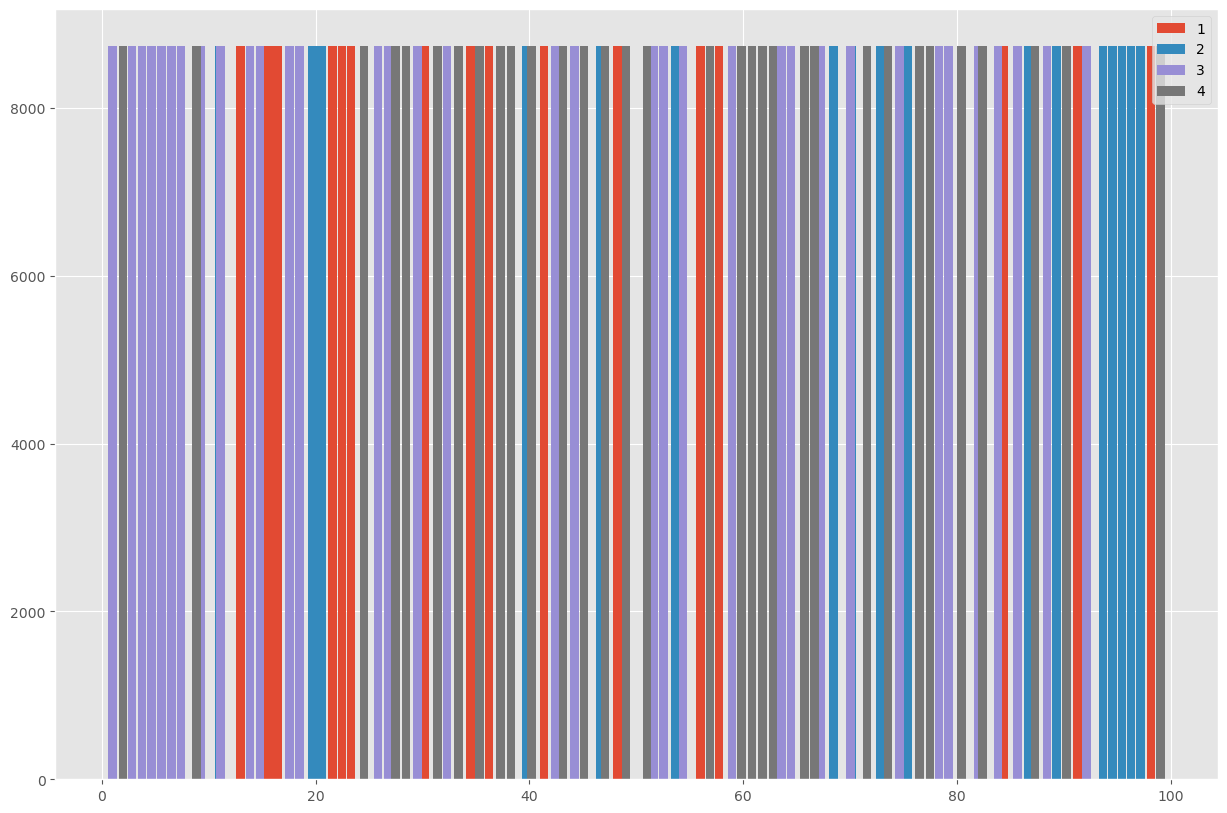

In [60]:
fig = plt.figure(figsize=(15,10))
for i in range(1,5):
    hist, edges = np.histogram(np.array(ids_per_model[i]), bins=100)
    plt.bar(edges[:-1], hist, label=f'{i}')

plt.legend()
plt.show()

Correlation based on age, component failures, error codes

In [67]:
labeled_features.loc[labeled_features.machineID==1].error1count.sum()

264.0

In [73]:
labeled_features.columns

Index(['datetime', 'machineID', 'volt_mean_3h', 'volt_std_3h',
       'rotate_mean_3h', 'rotate_std_3h', 'pressure_mean_3h',
       'pressure_std_3h', 'vibration_mean_3h', 'vibration_std_3h',
       'volt_mean_24h', 'volt_std_24h', 'rotate_mean_24h', 'rotate_std_24h',
       'pressure_mean_24h', 'pressure_std_24h', 'vibration_mean_24h',
       'vibration_std_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp1', 'comp2', 'comp3', 'comp4',
       'comp1_life', 'comp2_life', 'comp3_life', 'comp4_life', 'failure',
       'comp1_fail', 'comp2_fail', 'comp3_fail', 'comp4_fail'],
      dtype='object')

In [74]:
labeled_features.to_csv('../data/processed/data_processed_all.csv')



<AxesSubplot:>

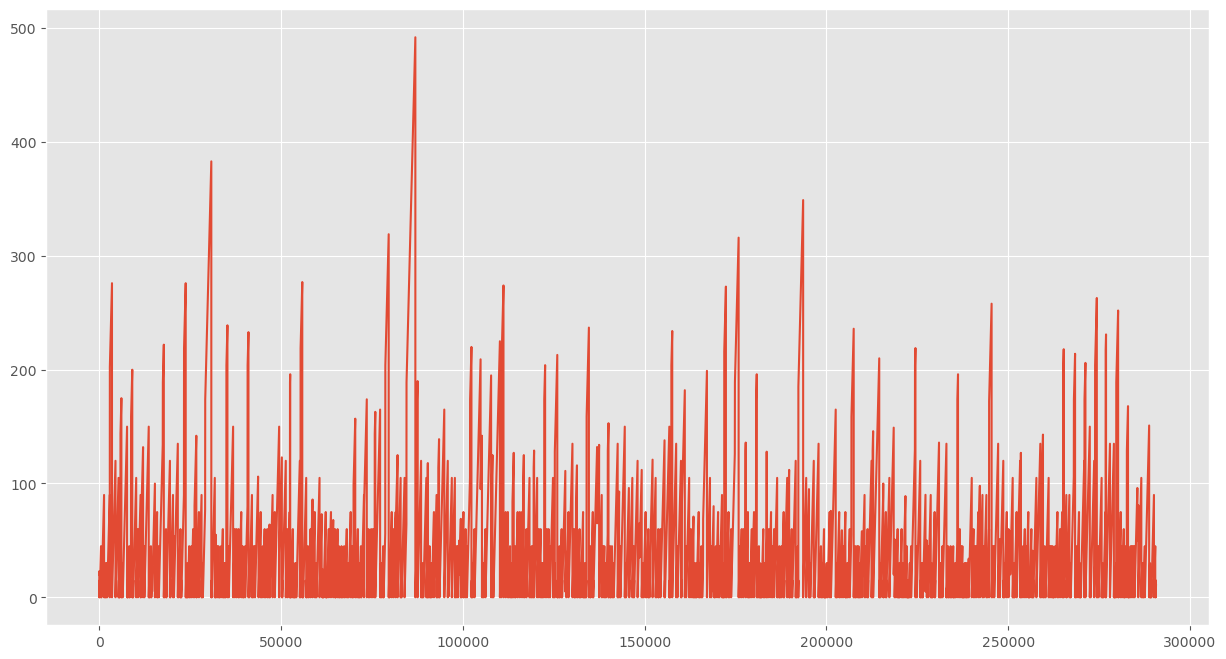

In [54]:
data['comp1'].plot()